In [1]:
import os 
import torch
import cv2
import numpy as np 
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from albumentations import Compose, RandomCrop, HorizontalFlip
from albumentations.pytorch import ToTensorV2
import torchvision

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns 


E:\Apps\Anaconda\envs\pytorch_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_PATH = 'Processed_Classifier_Dataset'
BATCH_SIZE = 16
TRAIN_SPLIT = 0.8
MODEL_NETWORK = 'resnet50'
LR = 0.001
MOMENTUM = 0.9
EPOCHS = 10

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
sorted(os.listdir(DATA_PATH))

['stroma', 'tumor']

In [7]:
# Define the dataset
class BreastCancerDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = sorted(os.listdir(data_dir))
        self.files = []
        for cls in self.classes:
            cls_dir = os.path.join(data_dir, cls)
            for file in os.listdir(cls_dir):
                self.files.append((os.path.join(cls_dir, file), cls))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path, cls = self.files[idx]
        image = Image.open(file_path)
        if self.transform:
            image = self.transform(image=np.array(image))['image']
        label = self.classes.index(cls)
        return image/255., label

In [8]:
# Define the data transformations
train_transform = Compose([
    RandomCrop(224, 224),
    HorizontalFlip(),
    ToTensorV2()
])

val_transform = Compose([
    RandomCrop(224, 224),
    ToTensorV2()
])

In [9]:
# Create the datasets and dataloaders
dataset = BreastCancerDataset(DATA_PATH,transform=train_transform)
train_size = int(TRAIN_SPLIT*len(dataset))
val_size = len(dataset)-train_size
train_dataset,val_dataset=random_split(dataset,[train_size,val_size])
val_dataset.dataset=BreastCancerDataset(DATA_PATH,transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [10]:
train_dataset.dataset.classes

['stroma', 'tumor']

In [48]:
# Define the model
# model = torch.hub.load('pytorch/vision:v0.10.0', MODEL_NETWORK, pretrained=True)
model = torchvision.models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(train_dataset.dataset.classes))
model = model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [49]:
# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)

In [50]:
# Train the model
num_epochs = EPOCHS
for epoch in range(num_epochs):
    # Train for one epoch
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)

    # Evaluate on the validation set
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    epoch_val_loss = running_loss / len(val_dataset)
    epoch_val_acc = running_corrects.double() / len(val_dataset)

    print(f'Epoch {epoch}/{num_epochs - 1}')
    print(f'Train Loss: {epoch_loss:.4f}')
    print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

Epoch 0/9
Train Loss: 0.5447
Val Loss: 0.4868 Acc: 0.8361
Epoch 1/9
Train Loss: 0.2787
Val Loss: 0.1344 Acc: 1.0000
Epoch 2/9
Train Loss: 0.2108
Val Loss: 0.1837 Acc: 0.9180
Epoch 3/9
Train Loss: 0.1065
Val Loss: 0.0543 Acc: 0.9836
Epoch 4/9
Train Loss: 0.0566
Val Loss: 0.0697 Acc: 0.9672
Epoch 5/9
Train Loss: 0.0423
Val Loss: 0.0490 Acc: 0.9836
Epoch 6/9
Train Loss: 0.0775
Val Loss: 0.0475 Acc: 0.9836
Epoch 7/9
Train Loss: 0.0698
Val Loss: 0.0530 Acc: 0.9672
Epoch 8/9
Train Loss: 0.1315
Val Loss: 0.1280 Acc: 0.9508
Epoch 9/9
Train Loss: 0.0630
Val Loss: 0.0127 Acc: 1.0000


In [52]:
torch.save(model,'ckpt/pretrained_classifier_stroma+tumor.pth')

# Performance Reports 

In [6]:
model = torch.load('ckpt/pretrained_classifier_stroma+tumor.pth').to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

              precision    recall  f1-score   support

      stroma       1.00      1.00      1.00        32
       tumor       1.00      1.00      1.00        29

    accuracy                           1.00        61
   macro avg       1.00      1.00      1.00        61
weighted avg       1.00      1.00      1.00        61



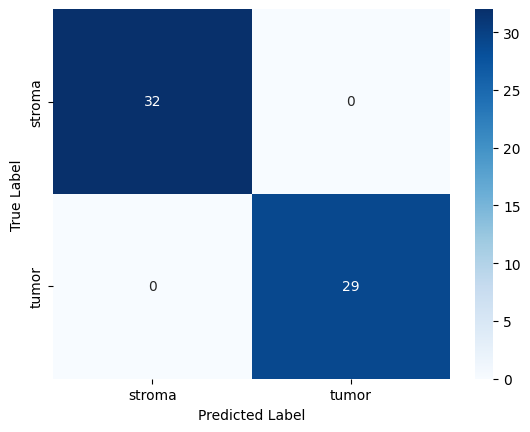

In [12]:
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs,labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _,preds = torch.max(outputs,1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        
report = classification_report(y_true,y_pred,target_names=dataset.classes)
print(report)

cm = confusion_matrix(y_true,y_pred)
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=dataset.classes,yticklabels=dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Inference 

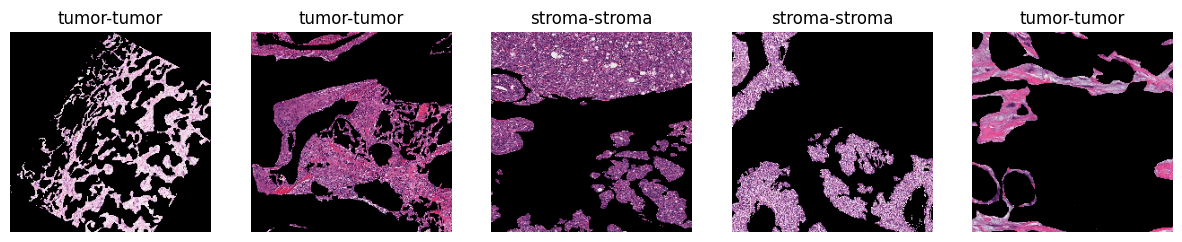

In [15]:
num_samples = 5
samples, labels =next(iter(val_dataloader))
samples = samples[:num_samples]
labels = labels[:num_samples]

with torch.no_grad():
    outputs = model(samples.to(device))
    _,preds = torch.max(outputs,1)
    preds = preds.cpu().numpy()

fig,ax = plt.subplots(1,num_samples,figsize=(15,3))
for i in range(num_samples):
    ax[i].imshow(samples[i].permute(1,2,0))
    ax[i].set_title(f'{dataset.classes[labels[i]]}-{dataset.classes[preds[i]]}')
    ax[i].axis('off')
    
plt.show()